# Advanced Methods in Bioinformatics 

## Secondary Structure Prediction, Influence of Protein Family and Using Evolutionary Information



## Introduction
In this assignment we are supposed to implement an algorithm to predict the secondary structure for the 498 proteins given in the Cath dataset, based on the stride and dssp sets that consist of the secondary structure for these proteins per residue. We are also supposed to predict the protein family for each protein based on the secondary structure predictions. For this assignment I will be implementing machine learning algorithms to see how well they can perform on such a problem. 

### Libraries 

In [31]:
import csv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import matthews_corrcoef
from sklearn.neural_network import MLPClassifier as mlp
from sklearn.model_selection import GridSearchCV
from yellowbrick.classifier import ROCAUC
#import xgboost as xgb
#from imblearn.over_sampling import RandomOverSampler

### Analyzing data
Here I have imported the datasets and named the columns based on the description in the assignment. I have also visualized the targets in each dataset using histograms to check for inconsistencies, it is obvious that Coil has more instances in both dssp and stride, however, it is not a large difference. Although, I had to replace any existance of Other to Coil as descriped in the assignment.
From cath histograms, we can see that Alpha/beta has slightly more instances than Alpha and Beta combined, therefore it's unbalanced.

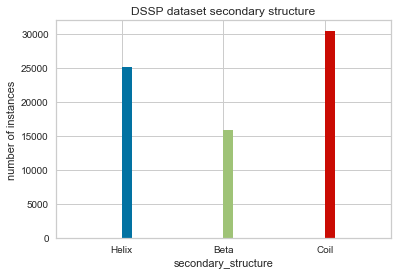

,PDB_code,PDB_chain_code,PDB_seq_code,residue_name,secondary_structure
0,1w0n,A,12,ILE,Coil
1,1w0n,A,13,THR,Beta
2,1w0n,A,14,LYS,Beta
3,1w0n,A,15,VAL,Beta
4,1w0n,A,16,GLU,Beta


In [32]:
#DSSP load and naming columns
dssp = pd.read_csv('dssp_info.txt', delimiter='\t', 
                   names= ['PDB_code','PDB_chain_code','PDB_seq_code','residue_name','secondary_structure'])

#replacing other by coil and dropping duplicates
dssp= dssp.replace("Other","Coil")
dssp = dssp.drop_duplicates()
#plotting the secondary structures
helix = dssp.loc[dssp['secondary_structure'] == 'Helix']
beta = dssp.loc[dssp['secondary_structure'] == 'Beta']
coil = dssp.loc[dssp['secondary_structure'] =='Coil']

helix['secondary_structure'].hist()
beta['secondary_structure'].hist()
coil['secondary_structure'].hist()
plt.xlabel('secondary_structure')
plt.ylabel('number of instances')
plt.title('DSSP dataset secondary structure')
plt.show()

#take a look at the first few rows of the dataset
dssp.head()
#dssp.info()

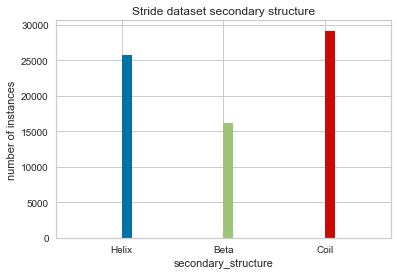

,PDB_code,PDB_chain_code,PDB_seq_code,residue_name,secondary_structure
0,1w0n,A,12,ILE,Coil
1,1w0n,A,13,THR,Beta
2,1w0n,A,14,LYS,Beta
3,1w0n,A,15,VAL,Beta
4,1w0n,A,16,GLU,Beta


In [33]:
#Stride load and naming columns
stride=pd.read_csv('stride_info.txt', delimiter='\t', names= ['PDB_code','PDB_chain_code','PDB_seq_code','residue_name','secondary_structure'])
#stride.info()

#replace other by coil dropping duplicates
stride= stride.replace("Other","Coil")
stride= stride.drop_duplicates()
#plotting based on the secondary structure 
helix = stride.loc[stride['secondary_structure'] == 'Helix']
beta = stride.loc[stride['secondary_structure'] == 'Beta']
coil = stride.loc[stride['secondary_structure'] == 'Coil']

helix['secondary_structure'].hist()
beta['secondary_structure'].hist()
coil['secondary_structure'].hist()
plt.xlabel('secondary_structure')
plt.ylabel('number of instances')
plt.title('Stride dataset secondary structure')
plt.show()

#taking a look at the first few rows
stride.head()

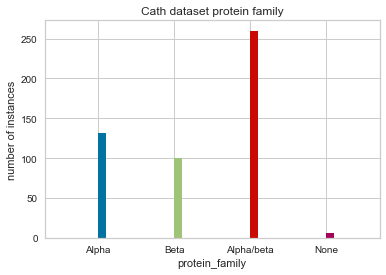

,PDB_code,PDB_chain_code,protein_family
0,1w0n,A,Beta
1,2gpi,A,Alpha/beta
2,1vbw,A,Alpha/beta
3,2odk,A,Alpha/beta
4,2zxy,A,Alpha


In [34]:
#load cath dataset and name columns
cath=pd.read_csv('cath_info.txt', delimiter='\t', names= ['PDB_code','PDB_chain_code','protein_family'])
#cath= cath.replace("None","Beta")

#dropping duplicates
cath= cath.drop_duplicates()

#plotting based on the protein family
alpha = cath.loc[cath['protein_family'] == 'Alpha']
beta = cath.loc[cath['protein_family'] == 'Beta']
alpha_beta = cath.loc[cath['protein_family'] == 'Alpha/beta']
other = cath.loc[cath['protein_family'] == 'None']

alpha['protein_family'].hist()
beta['protein_family'].hist()
alpha_beta['protein_family'].hist()
other['protein_family'].hist()
plt.xlabel('protein_family')
plt.ylabel('number of instances')
plt.title('Cath dataset protein family')
plt.show()

#taking a look at the first rows
cath.head()


### Data Preprocessing
Before implementing machine learning algorithms the data should be formatted. Here, I have separated the classes (targets) which is the secondary structure from the datasets and then I had to encode the data in order for the algorithms to understand it since the data types were all objects. After encoding the secondary structures will be represented by numbers; 0 is for beta , 1 is for coil and 2 is for helix. The encoding of cath is represented by numbers as well, however, for the protein family 0 is for alpha, 1 is for alpha/beta, 2 is for beta and 3 is for none.

In [35]:
#split both dssp and stride for x and y where x is the data without the secondary structure and y is the secondary structure
X_dssp= dssp.drop('secondary_structure', axis=1)
y_dssp= pd.DataFrame(dssp['secondary_structure'])
X_stride= stride.drop('secondary_structure', axis=1)
y_stride= pd.DataFrame(stride['secondary_structure'])

In [36]:
#encoding the the x and y from both dssp and stride
encoder=OrdinalEncoder()
encoder.fit(X_dssp)
X_dssp_enc= encoder.transform(X_dssp)

encoder.fit(y_dssp)
y_dssp_enc= encoder.transform(y_dssp)
#encoder.categories_

encoder.fit(X_stride)
X_stride_enc= encoder.transform(X_stride)

encoder.fit(y_stride)
y_stride_enc= encoder.transform(y_stride)

#encoding cath dataset
encoder.fit(cath)
cath_enc= encoder.transform(cath)


### Training Classifier
I have tried to implement several algorithms to check which one will give the highest accuracy. K- Nearest Neighbors was the best that's why I have implemented it on both DSSP and Stride. Knn is an algorithm that is used for classification and regression problems, in this case it's classification. The algorithm classifies a data point based on how its neigbors are classified, it measures the distance from the new data to all other data that is already classified then it gets the k smaller distances, after that it checks the list of classes with the shortest distance and counts how many times each class appeared, the new data will be classified based on the class that appeared the most.

### DSSP
First, I had to split the data into training and testing sets, my testing sets will be 33% of the whole datasets. After splitting, I have trained the knn with k=1 (I have tried k=3 and k=5 ,however, k=1 was the best). After getting predictions, I have applied cross validation with k=10, which means the dataset will be shuffled and splitted into 10 groups. One group will be held as a test set and the rest will be for training, then in my case the knn will be fitted on these 9 groups of training sets and evaluated on the remaining test set. The same will occure until we get 10 different scores. In the end I have checked the results for Q3 and MCC.

In [37]:
# Split into training and test sets
X_dssp_train, X_dssp_test, y_dssp_train, y_dssp_test = train_test_split(X_dssp_enc, y_dssp_enc, test_size=0.33, random_state=42)

#applying knn classifier with k as 1
clf = KNeighborsClassifier(n_neighbors=1)
clf.fit(X_dssp_train,y_dssp_train.ravel())

#predictions of knn
dssp_predictions= clf.predict(X_dssp_test)
dssp_predictions

array([0., 2., 2., ..., 0., 0., 1.])

In [38]:
#applying 10 fold cross validation
cv = ShuffleSplit(n_splits=10)
dssp_scores = cross_val_score(clf,X_dssp_test,y_dssp_test.ravel() , cv=cv)
print(dssp_scores)

#taking a look at the confusion matrix 
confusion= confusion_matrix(y_dssp_test.ravel(), dssp_predictions)
print('confusion matrix:')
print(confusion)
#clf.classes_
#0 -> beta 
#1 -> coil
#2 -> helix

[0.51655348 0.52207131 0.49872666 0.50127334 0.51952462 0.49490662
 0.52079796 0.51443124 0.52122241 0.51103565]
confusion matrix:
[[2456 1754 1074]
 [1800 6015 2345]
 [1024 2278 4814]]


In [39]:
# calculating Q3 and MCC scores
print("The Q3 score for Dssp: %f" % accuracy_score(y_dssp_test,dssp_predictions))
print("The MCC score for Dssp: %f " %matthews_corrcoef(y_dssp_test,dssp_predictions))


The Q3 score for Dssp: 0.563879
The MCC score for Dssp: 0.324338 


D:\School\python\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


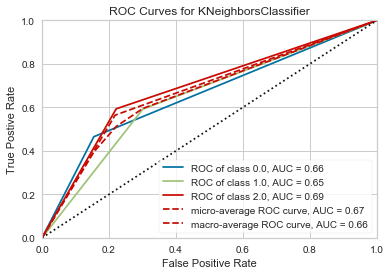

In [40]:
class_names= clf.classes_
#instantiate the roc curve with the rf model
visualizer = ROCAUC(clf, classes=class_names)
#fitting training data to the roc curve
visualizer.fit(X_dssp_train, y_dssp_train.ravel())  
#evaluate the model on the test data
visualizer.score(X_dssp_test, y_dssp_test.ravel())  
visualizer.poof()

### Stride
Here, I have followed what I have done for DSSP, splitting the dataset into training and testing, applying knn with k=1 and cross validation with k=10. Lastly, I have checked the Q3 and MCC scores, we can see that stride has slightly better scores than dssp.

In [52]:
# Split into training and test sets
X_stride_train, X_stride_test, y_stride_train, y_stride_test = train_test_split(X_stride_enc, y_stride_enc, test_size=0.33, random_state=42)

#applying knn classifier with k as 1
clf = KNeighborsClassifier(n_neighbors=1)
clf.fit(X_stride_train,y_stride_train.ravel())

#predictions of knn
stride_predictions= clf.predict(X_stride_test)
print(stride_predictions)

[2. 2. 2. ... 1. 1. 2.]


In [53]:
#applying 10 fold cross validation
stride_scores = cross_val_score(clf,X_stride_test,y_stride_test.ravel() , cv=cv)
stride_scores

array([0.5       , 0.50383632, 0.49957374, 0.50341006, 0.51321398,
       0.52046036, 0.51875533, 0.50341006, 0.50895141, 0.52898551])

In [54]:
# calculating Q3 and MCC scores
print("The Q3 score for Stride: %f" % accuracy_score(y_stride_test,stride_predictions))
print("The MCC score for Stride: %f " %matthews_corrcoef(y_stride_test,stride_predictions))


The Q3 score for Stride: 0.570217
The MCC score for Stride: 0.337140 


D:\School\python\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


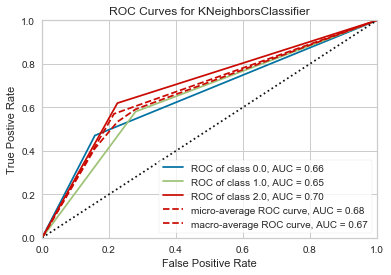

In [55]:
#instantiate the roc curve with the rf model
visualizer = ROCAUC(clf, classes=class_names)
#fitting training data to the roc curve
visualizer.fit(X_stride_train, y_stride_train.ravel())  
#evaluate the model on the test data
visualizer.score(X_stride_test, y_stride_test.ravel())  
visualizer.poof()

### Protein Family Prediction
For this problem, I have decided to implement machine learning algorithms again on the secondary structure predictions and see how that works. First, I had to repredict secondary structures for both dssp and stride, however, this time I will predict on the x sets as a whole because I need to merge the results of predictions with the datasets which was not possible because the predictions were only on 33% of the dataset. After predicting on the whole datasets, I applied cross validation which now shows way better scores. After that, I have created a dataframe from the encoded cath set and renamed columns again for clarifications since all we can see now is float numbers. And for the new full predictions, I have merged them with the encoded x set which doesn't have the actual secondary structure. After that, I have created a dataframe from that set and renamed its columns, then I merged it with the new dataframe of cath. Then, I have split it into X and Y where Y is the protein family and X is the secondary structure prediction. And again I split them into training and testing sets, and tried different algorithms to see what's best, however, they were all performing strangely. For example, knn with k=1 gave a Q3 of 0.4 and MCC of -0.05, neural networks and random forest gave a Q3 of around 0.58 and an MCC of 0. Therefore, I've chosen random forest which is an ensemble model made up of many decision trees. I have tried to change its parameters using grid search to find the optimized combination of parameters however nothing changed. It seems to be generalizing since the cath dataset is not balanced and no matter what it gives the prediction of protein family as Alpha/beta since its 58% of the times accurate. Furthermore, I have tried to oversample and undersample the datasets, however, the results were worse since the algorithms started favoring the minority classes which are none or beta, in its best the Q3 score was around 0.2 and MCC score was 0.01. 
In the end, I have joined all secondary structure predictions with their correspondent PDB_Code for both Stride and Dssp.

### DSSP 

In [56]:
#prediciting on the whole X using same knn 
pred = clf.predict(X_dssp_enc)
#cross validation on the new x and y
alldssp_scores = cross_val_score(clf,X_dssp_enc,pred.ravel() , cv=cv)
alldssp_scores

array([0.72969188, 0.73123249, 0.72703081, 0.72521008, 0.72156863,
       0.72773109, 0.71848739, 0.72661064, 0.73389356, 0.72997199])

In [57]:
#creating a dataframe for cath from the encoded cath and give each column their name 
enc_cathdf= pd.DataFrame.from_records(cath_enc)
enc_cathdf= enc_cathdf.rename(columns={0: "PDB_code", 1: "PDB_chain_code",2:'protein_family'})

In [58]:
#merging the new full predictions with the encoded dssp
dssp_with_pred = np.column_stack([X_dssp_enc,pred]) 
dssp_with_pred
##creating a dataframe for dssp from the encoded dssp and give each column their name 
enc_dssp_pred= pd.DataFrame.from_records(dssp_with_pred)
enc_dssp_pred= enc_dssp_pred.rename(columns={0: "PDB_code", 1: "PDB_chain_code",2:'PDB_seq_code',3:'residue_name',4:'secondary_structure_prediction' })
#merging dssp with cath
dssp_cath=pd.merge(enc_dssp_pred,enc_cathdf ,how='outer')
dssp_cath.head()

,PDB_code,PDB_chain_code,PDB_seq_code,residue_name,secondary_structure_prediction,protein_family
0,217.0,0.0,31.0,18.0,2.0,2.0
1,217.0,0.0,32.0,25.0,0.0,2.0
2,217.0,0.0,33.0,20.0,0.0,2.0
3,217.0,0.0,34.0,28.0,0.0,2.0
4,217.0,0.0,35.0,15.0,2.0,2.0


In [59]:
#creating x and y for dssp_cath to predict protein family based on the ss prediction
X_dssp_cath= pd.DataFrame(dssp_cath['secondary_structure_prediction'])
y_dssp_cath= pd.DataFrame(dssp_cath['protein_family'])


In [61]:
# Split into training and test sets
X_dssp_cath_train, X_dssp_cath_test, y_dssp_cath_train, y_dssp_cath_test = train_test_split(X_dssp_cath, 
y_dssp_cath, test_size=0.33, random_state=42)

#training classifier
clf2 = RandomForestClassifier()
#clf3= KNeighborsClassifier(n_neighbors=1)
#net = mlp(hidden_layer_sizes=(500,), activation='tanh', alpha = 0.001, solver='lbfgs', max_iter=2000)
clf2.fit(X_dssp_cath_train,y_dssp_cath_train.values.ravel())

#predictions of random forest
dssp_cath_predictions= clf2.predict(X_dssp_cath_test)
dssp_cath_predictions

array([1., 1., 1., ..., 1., 1., 1.])

In [62]:
#10 fold cross validation on random forest
cath_dssp_scores = cross_val_score(clf2,X_dssp_cath_test,y_dssp_cath_test.values.ravel() , cv=cv)
cath_dssp_scores

array([0.58234295, 0.57937182, 0.59677419, 0.5827674 , 0.58149406,
       0.57682513, 0.60101868, 0.5844652 , 0.58998302, 0.59295416])

In [103]:
#param_grid has all parameters that gridSearch will be using to choose the best combination which gives the best random forest
param_grid = {
    'max_depth': [80, 90, 100],
    'min_samples_split': [8,10,12],
    'n_estimators': [100, 500, 1000]
}    
grid_search = GridSearchCV(estimator = clf2, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)
grid_search.fit(X_dssp_cath_train,y_dssp_cath_train.values.ravel())
bestParam= grid_search.best_params_
best_forest = grid_search.best_estimator_
print(best_forest)
bestParam

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   25.9s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:  1.2min finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=90, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


{'max_depth': 90, 'min_samples_split': 10, 'n_estimators': 1000}

In [63]:
#applying random forest after grid search result
clf2 = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=90, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
#clf3= KNeighborsClassifier(n_neighbors=1)
#net = mlp(hidden_layer_sizes=(500,), activation='tanh', alpha = 0.001, solver='lbfgs', max_iter=2000)

clf2.fit(X_dssp_cath_train,y_dssp_cath_train.values.ravel())

#predictions of random forest based on the whole x of dssp and cath
dssp_cath_predictions= clf2.predict(X_dssp_cath)
dssp_cath_predictions

array([1., 1., 1., ..., 1., 1., 1.])

In [64]:
# calculating Q3 and MCC scores
print("The Q3 score for Dssp Protein family prediction: %f" % accuracy_score(y_dssp_cath,dssp_cath_predictions))
print("The MCC score for Dssp Protein family prediction: %f " %matthews_corrcoef(y_dssp_cath,dssp_cath_predictions))

The Q3 score for Dssp Protein family prediction: 0.582496
The MCC score for Dssp Protein family prediction: 0.000000 


D:\School\python\lib\site-packages\sklearn\metrics\_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


In [65]:
#joining all ss predictions for dssp and grouping them by pdb_code
enc_dssp_pred['secondary_structure_prediction'] = enc_dssp_pred['secondary_structure_prediction'].astype(str)
dssp_final_predictions=enc_dssp_pred.reset_index().groupby('PDB_code',sort=False).agg({ 'secondary_structure_prediction': lambda x: ', '.join(x)})
dssp_final_predictions.head()
#dssp_final_predictions.to_csv("dssp_final_predictions.csv", index=True)

,secondary_structure_prediction
PDB_code,
217.0,"2.0, 0.0, 0.0, 0.0, 2.0, 2.0, 2.0, 1.0, 0.0, 2..."
304.0,"1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1..."
207.0,"1.0, 1.0, 1.0, 1.0, 0.0, 2.0, 2.0, 2.0, 2.0, 2..."
336.0,"2.0, 0.0, 0.0, 0.0, 2.0, 2.0, 1.0, 2.0, 2.0, 0..."
404.0,"1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 2.0, 2.0, 0..."


D:\School\python\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


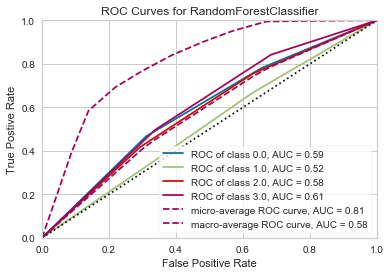

In [66]:
class_names= clf2.classes_
#instantiate the roc curve with the rf model
visualizer = ROCAUC(clf2, classes=class_names)
#fitting training data to the roc curve
visualizer.fit(X_dssp_cath_train, y_dssp_cath_train.values.ravel())  
#evaluate the model on the test data
visualizer.score(X_dssp_cath_test, y_dssp_cath_test)  
visualizer.poof() 

### Stride

In [67]:
#prediciting on the whole X using same knn 
pred2 = clf.predict(X_stride_enc)
#cross validation on the new x and y
allStride_scores = cross_val_score(clf,X_stride_enc,pred2.ravel() , cv=cv)
allStride_scores

array([0.72917839, 0.72087788, 0.721722  , 0.73002251, 0.72495779,
       0.72326956, 0.71876759, 0.72819358, 0.72847496, 0.72439505])

In [68]:
#merging the new full predictions with the encoded stride
stride_with_pred = np.column_stack([X_stride_enc,pred2]) 
stride_with_pred
##creating a dataframe for dssp from the encoded dssp and give each column their name 
enc_stride_pred= pd.DataFrame.from_records(stride_with_pred)
enc_stride_pred= enc_stride_pred.rename(columns={0: "PDB_code", 1: "PDB_chain_code",2:'PDB_seq_code',3:'residue_name',4:'secondary_structure_prediction' })
#merging dssp with cath
stride_cath=pd.merge(enc_stride_pred,enc_cathdf ,how='outer')
stride_cath.head()

,PDB_code,PDB_chain_code,PDB_seq_code,residue_name,secondary_structure_prediction,protein_family
0,217.0,0.0,31.0,9.0,1.0,2.0
1,217.0,0.0,32.0,16.0,0.0,2.0
2,217.0,0.0,33.0,11.0,0.0,2.0
3,217.0,0.0,34.0,20.0,0.0,2.0
4,217.0,0.0,35.0,6.0,2.0,2.0


In [69]:
#creating x and y for stride_cath to predict protein family based on the ss prediction
X_stride_cath= pd.DataFrame(stride_cath['secondary_structure_prediction'])
y_stride_cath= pd.DataFrame(stride_cath['protein_family'])


In [70]:
# Split into training and test sets
X_stride_cath_train, X_stride_cath_test, y_stride_cath_train, y_stride_cath_test = train_test_split(X_stride_cath, 
y_stride_cath, test_size=0.33, random_state=42)

#training classifier
clf2 = RandomForestClassifier()
#clf3= KNeighborsClassifier(n_neighbors=1)
#net = mlp(hidden_layer_sizes=(500,), activation='tanh', alpha = 0.001, solver='lbfgs', max_iter=2000)
clf2.fit(X_stride_cath_train,y_stride_cath_train.values.ravel())

#predictions of random forest
stride_cath_predictions= clf2.predict(X_stride_cath_test)
stride_cath_predictions

array([1., 1., 1., ..., 1., 1., 1.])

In [71]:
#10 fold cross validation on random forest
cath_stride_scores = cross_val_score(clf2,X_stride_cath_test,y_stride_cath_test.values.ravel() , cv=cv)
cath_stride_scores

array([0.5771526 , 0.56820119, 0.57800512, 0.57033248, 0.58098892,
       0.56436488, 0.5831202 , 0.58184143, 0.57971014, 0.57971014])

In [72]:
#predictions of random forest based on the whole x of stride and cath
stride_cath_predictions= clf2.predict(X_stride_cath)
#np.savetxt("stride_cath_predictions.csv", stride_cath_predictions, delimiter=",")
stride_cath_predictions

array([1., 1., 1., ..., 1., 1., 1.])

In [73]:
# calculating Q3 and MCC scores
print("The Q3 score for Stride Protein family prediction: %f" % accuracy_score(y_stride_cath,stride_cath_predictions))
print("The MCC score for Stride Protein family prediction: %f " %matthews_corrcoef(y_stride_cath,stride_cath_predictions))

The Q3 score for Stride Protein family prediction: 0.582340
The MCC score for Stride Protein family prediction: 0.000000 


D:\School\python\lib\site-packages\sklearn\metrics\_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


In [74]:
#joining all ss predictions for stride and grouping them by pdb_code
stride_cath['secondary_structure_prediction'] = stride_cath['secondary_structure_prediction'].astype(str)
stride_final_predictions=stride_cath.reset_index().groupby('PDB_code',sort=False).agg({ 'secondary_structure_prediction': lambda x: ', '.join(x)})
stride_final_predictions.head()
#stride_final_predictions.to_csv("stride_final_predictions.csv", index=True)

,secondary_structure_prediction
PDB_code,
217.0,"1.0, 0.0, 0.0, 0.0, 2.0, 1.0, 2.0, 1.0, 1.0, 0..."
304.0,"1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 2.0, 1..."
207.0,"1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1..."
336.0,"0.0, 0.0, 0.0, 0.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2..."
404.0,"1.0, 1.0, 2.0, 0.0, 2.0, 0.0, 2.0, 2.0, 2.0, 2..."


D:\School\python\lib\site-packages\sklearn\base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


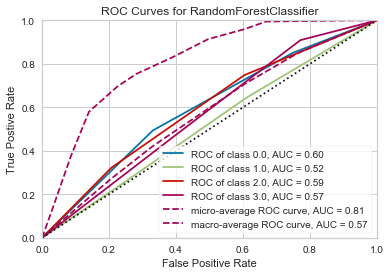

In [76]:
#instantiate the roc curve with the rf model
visualizer = ROCAUC(clf2, classes=class_names)
#fitting training data to the roc curve
visualizer.fit(X_stride_cath_train, y_stride_cath_train.values.ravel())  
#evaluate the model on the test data
visualizer.score(X_stride_cath_test, y_stride_cath_test.values.ravel())  
visualizer.poof() 

### Combining ML with MSA 
For this step, I got my multiple sequence alignment from clustral omega, I was't sure how to process the data in order to use the same classifier, I have tried to reshape it but it didn't work, thus I added the msa as residue_name and I added the missing column which was the PDB_seq_code with zero values. I was able to use the same classifier to predict after encoding the new data, however, it doesn't give anything but 1 which stands for coil. I think the encoding for MSA could be the reason since it is only one letter and it is not similar to what the classifier had trained on. 

In [77]:
#loading the new msa set and preprocess it
msa = pd.read_csv('msa.txt', delimiter=';',names=['PDB_code','PDB_chain_code','residue_name'])
msa = msa.set_index(['PDB_code','PDB_chain_code']).apply(lambda x: x.str.split(',').explode()).reset_index()
msa.head()

,PDB_code,PDB_chain_code,residue_name
0,1ava,C,L
1,1ava,C,G
2,1ava,C,V
3,1ava,C,F
4,1ava,C,R


In [78]:
#get missing columns
missing_cols = set(X_dssp.columns)  - set(msa.columns)
#adding a missing column in test set with default value equal to 0
for c in missing_cols:
    msa[c] = 0
#ensure the order of column in the test set is in the same order in train set
msa = msa[X_dssp.columns]
msa.head()

,PDB_code,PDB_chain_code,PDB_seq_code,residue_name
0,1ava,C,0,L
1,1ava,C,0,G
2,1ava,C,0,V
3,1ava,C,0,F
4,1ava,C,0,R


In [79]:
#encoding the set
encoder.fit(msa)
msa_enc= encoder.transform(msa)
#msa_enc.shape
#msa_enc= msa_enc.reshape(19,4)
#using the knn to predict the ss on the new set
clf.predict(msa_enc)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

### Conclusion
Machine learning algorithms performed better on predicting the secondary structure than on predicting protein family, Although, the MCC score wasn't that good, however, it's better than 0 which corresponds to a random prediction. The "stride_final_predictions" and "dssp_final_predictions" show the secondary structure predictions per protein for stride and dssp. The only problem was that I couldn't decode them back to the original form. However, I made sure that the proteins are still in the same order that was given in cath. Moreover, the predictions consist of zeros, ones and twos which I also couldn't replace by Beta, Coil and Helix respectively. To conclude, the classifiers used were K- nearest neighbors and Random forest where knn was used to predict the secondary structure twice for dssp and then stride and random forest was used twice to predict protein family for the two sets. After each prediction, the Roc curve has been plotted to compare the performance of each classifer and how well they perfromed on each class, the best would be if the area under the curve (AUC) is closer to 1 on the y-axis and the worst would be if it's closer to 1 on the x-axis which will mean that everything is classified wrong. Although, an AUC of 0.5 doesn't represent a good result; it means that the classifier can't distinguish between classes. We can see that the first two roc curves show some good results where the AUC is almost 0.7 for the Helix, and the lowest was for the Coil where it was 0.65. However, for the last two roc curves, we can see that for the Alpha/beta class the AUC is almost 0.5. However, it's strange for the other classes, since it shows an AUC closer to 0.6 where none of them was actually classified correctly. Lastly, I would like to mention that in the beginning I have merged the three datasets and tried to predict the secondary stucture and it gave better results which means that knowing the protein family would help predicting the protein secondary structures. 